In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
from datetime import date
API_KEY = "6rYVd16Fb8IvDpMF84BM4CB0M4Uabuh9"
symbol = "AAPL"
start_date = "2024-01-01"

url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{start_date}/{date.today()}"

params = {
    "adjusted": "true",
    "sort": "asc",
    "limit": 5000,
    "apiKey": API_KEY
}

response = requests.get(url, params=params)
data = response.json()

# Convert to DataFrame
results = data.get("results", [])
df = pd.DataFrame(results)
df.head()

,v,vw,o,c,h,l,t,n
0,81964874.0,185.9465,187.150,185.64,188.4400,183.885,1704171600000,1008871
1,58414460.0,184.3226,184.220,184.25,185.8800,183.430,1704258000000,656853
2,71878670.0,182.0183,182.150,181.91,183.0872,180.880,1704344400000,712692
3,62371161.0,181.4740,181.990,181.18,182.7600,180.170,1704430800000,682334
4,59144470.0,184.3702,182.085,185.56,185.6000,181.500,1704690000000,669173


In [3]:
# Convert timestamps
df["t"] = pd.to_datetime(df["t"], unit="ms")
df.rename(columns={
    "t": "Date", "o": "Open", "h": "High", "l": "Low",
    "c": "Close", "v": "Volume", "vw": "VWAP", "n": "Transactions"
}, inplace=True)

In [4]:
stock_data = df.copy()
stock_data.head(10)

,Volume,VWAP,Open,Close,High,Low,Date,Transactions
0,81964874.0,185.9465,187.150,185.64,188.4400,183.885,2024-01-02 05:00:00,1008871
1,58414460.0,184.3226,184.220,184.25,185.8800,183.430,2024-01-03 05:00:00,656853
2,71878670.0,182.0183,182.150,181.91,183.0872,180.880,2024-01-04 05:00:00,712692
3,62371161.0,181.4740,181.990,181.18,182.7600,180.170,2024-01-05 05:00:00,682334
4,59144470.0,184.3702,182.085,185.56,185.6000,181.500,2024-01-08 05:00:00,669173
5,42841809.0,184.3706,183.920,185.14,185.1500,182.730,2024-01-09 05:00:00,538180
6,46192908.0,185.2509,184.350,186.19,186.4000,183.920,2024-01-10 05:00:00,554777
7,49128408.0,185.0604,186.540,185.59,187.0500,183.620,2024-01-11 05:00:00,584008
8,40477782.0,185.8199,186.060,185.92,186.7400,185.190,2024-01-12 05:00:00,477050
9,65076641.0,182.8866,182.160,183.63,184.2600,180.934,2024-01-16 05:00:00,767281


In [5]:
stock_data["Date"] = stock_data["Date"].dt.date
stock_data.set_index("Date", inplace = True) #format of date is yyyy-mm-dd
stock_data.head()

,Volume,VWAP,Open,Close,High,Low,Transactions
Date,,,,,,,
2024-01-02,81964874.0,185.9465,187.150,185.64,188.4400,183.885,1008871
2024-01-03,58414460.0,184.3226,184.220,184.25,185.8800,183.430,656853
2024-01-04,71878670.0,182.0183,182.150,181.91,183.0872,180.880,712692
2024-01-05,62371161.0,181.4740,181.990,181.18,182.7600,180.170,682334
2024-01-08,59144470.0,184.3702,182.085,185.56,185.6000,181.500,669173


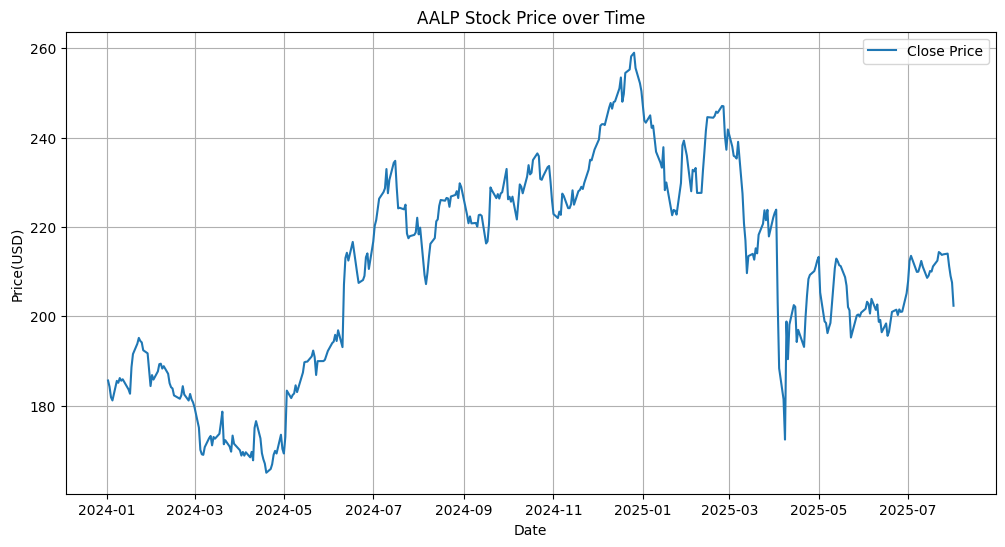

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], label="Close Price")
plt.xlabel("Date")
plt.ylabel("Price(USD)")
plt.title("AALP Stock Price over Time")
plt.legend()
plt.grid(True)
plt.show()

## Classical Time Series Decomposition

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_additive = seasonal_decompose(stock_data['Close'], model='additive', period=30) #30days gap

In [8]:
trend_additive = decomposition_additive.trend
seasonal_additive = decomposition_additive.seasonal
residual_additive = decomposition_additive.resid

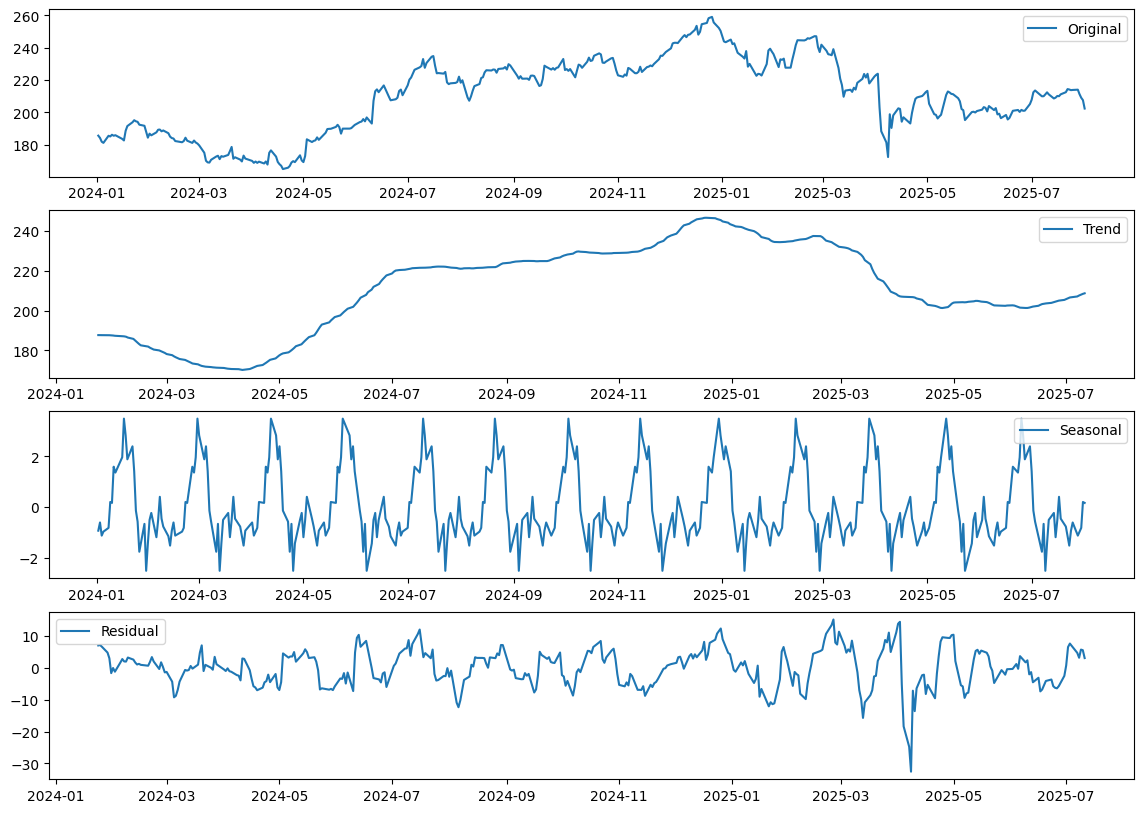

In [9]:
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(stock_data['Close'], label="Original")
plt.legend()
plt.subplot(412)
plt.plot(trend_additive, label="Trend")
plt.legend()
plt.subplot(413)
plt.plot(seasonal_additive, label="Seasonal")
plt.legend()
plt.subplot(414)
plt.plot(residual_additive, label="Residual")
plt.legend()
plt.show()


## STL Decomposition

In [10]:
from statsmodels.tsa.seasonal import STL

stl = STL(stock_data['Close'], period=30)
result = stl.fit()

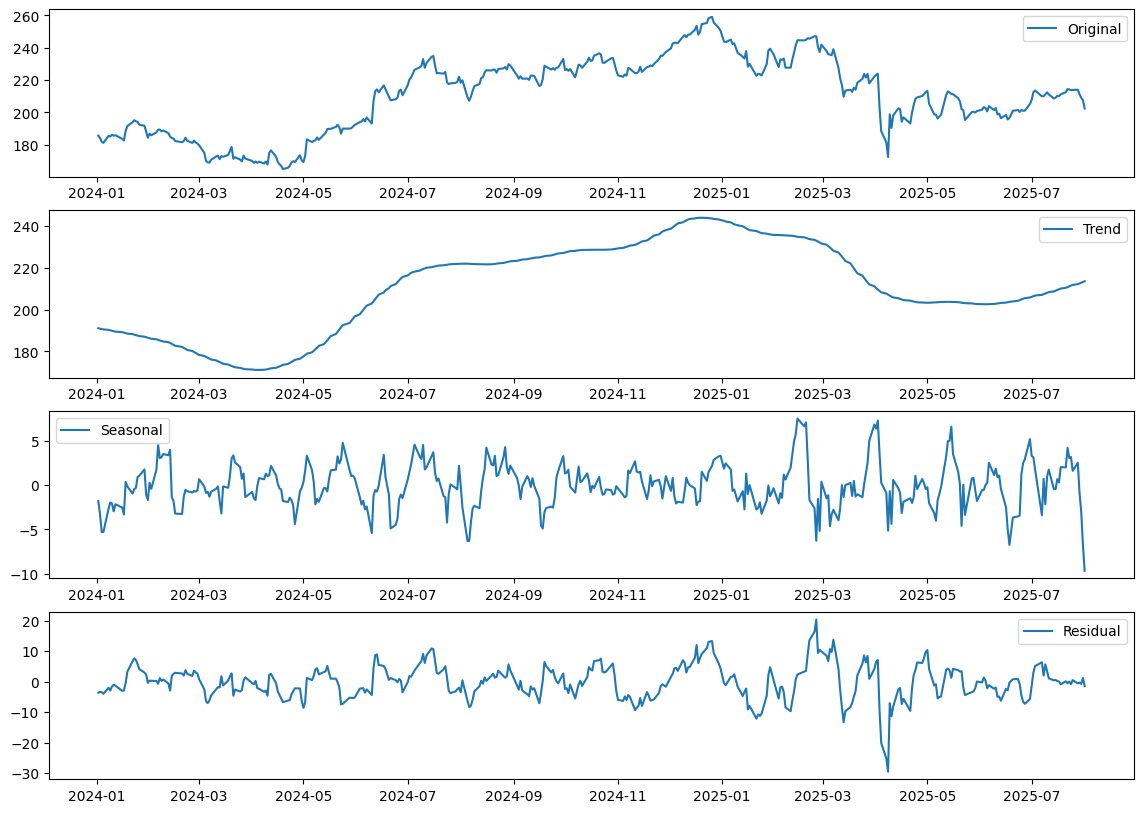

In [11]:
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(stock_data['Close'], label="Original")
plt.legend()
plt.subplot(412)
plt.plot(result.trend, label="Trend")
plt.legend()
plt.subplot(413)
plt.plot(result.seasonal, label="Seasonal")
plt.legend()
plt.subplot(414)
plt.plot(result.resid, label="Residual")
plt.legend()
plt.show()

## Stationarity Test

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
# doing the ADF test
adf_test = adfuller(stock_data['Close'])
print('ADF Test Results: ')
print(f"ADF Statistic: {round(adf_test[0], 3)}")
print(f"p-value: {round(adf_test[1], 3)}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"{key}: {round(value, 3)}")

ADF Test Results: 
ADF Statistic: -1.909
p-value: 0.328
Critical Values:
1%: -3.447
5%: -2.869
10%: -2.571


Since p-value > 0.05, we fail to reject the null hypothesis. The data is non stationary.

In [14]:
from statsmodels.tsa.stattools import kpss

In [16]:
# doing the kpss test
kpss_test = kpss(stock_data['Close'])#regression=ct or c
print('KPSS Test Results: ')
print(f"KPSS Statistic: {round(kpss_test[0], 3)}")
print(f"p-value: {round(kpss_test[1], 3)}")
print("Critical Values:")
for key, value in kpss_test[3].items():
    print(f"{key}: {round(value, 3)}")

KPSS Test Results: 
KPSS Statistic: 1.375
p-value: 0.01
Critical Values:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


/tmp/ipykernel_111811/3853705080.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(stock_data['Close'])


Since p-value < 0.05, we reject the null hypothesis. The data is non stationary.

Since our data is non stationary, to demonstrate weak stationary and strict stationary data, we will create synthetic data using the normal distribution.

### Stationarity Tests on Synthetic Data

/tmp/ipykernel_111811/3704067462.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_111811/3704067462.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


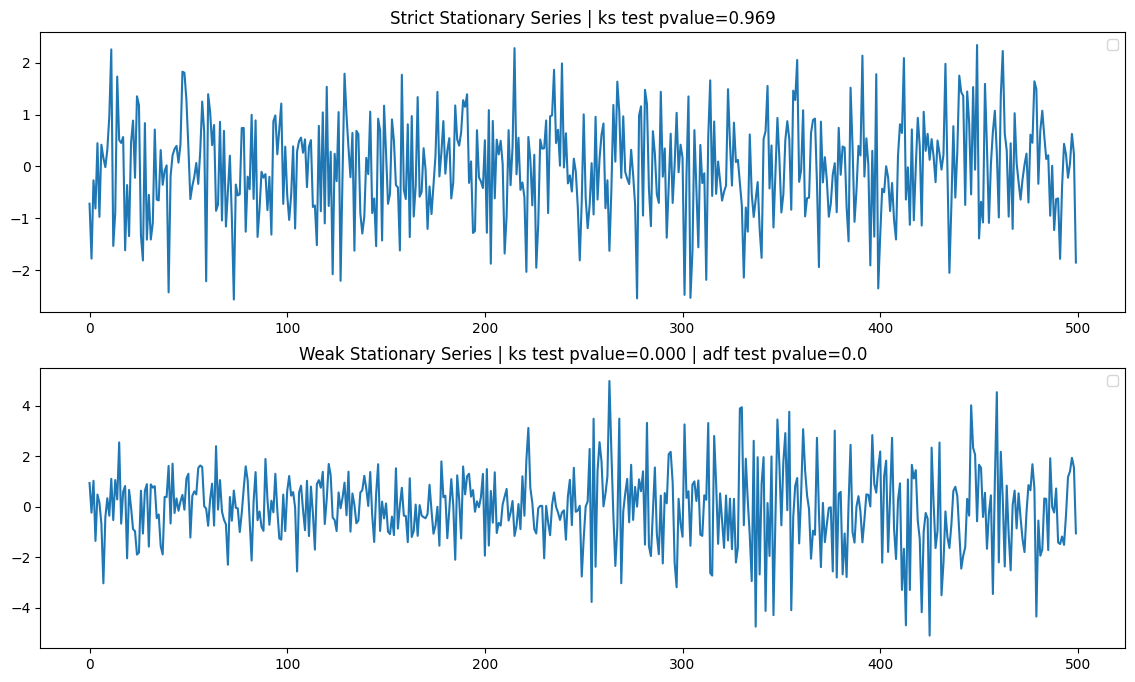

In [25]:
import numpy as np
from scipy.stats import ks_2samp
from datetime import datetime

seed = int(datetime.now().timestamp())
np.random.seed(seed)
n = 500

strict_stationary_series = np.random.normal(0, 1, n)

weak_stationary_series = np.concatenate([
    np.random.normal(0, 1, n//2),
    np.random.normal(0, 2, n//2)
])

def ks_test_stationarity(series):
    split = len(series)//2
    series_first_half = series[:split]
    series_second_half = series[split:]
    stat, p_value = ks_2samp(series_first_half, series_second_half)
    return stat, p_value

# perform ks test on strict stationary data
ks_stat_strict, ks_pvalue_strict = ks_test_stationarity(strict_stationary_series)
# perform ks test on weak stationary data
ks_stat_weak, ks_pvalue_weak = ks_test_stationarity(weak_stationary_series)

# doing the ADF test
adf_test = adfuller(weak_stationary_series)
adf_pvalue = round(adf_test[1], 3)
    
#plot the series
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)  # (nrows=2, ncols=1, index=1)
plt.title(f"Strict Stationary Series | ks test pvalue={ks_pvalue_strict:.3f}")
plt.plot(strict_stationary_series)
plt.legend()
plt.subplot(2, 1, 2)  # (nrows=2, ncols=1, index=2)
plt.title(f"Weak Stationary Series | ks test pvalue={ks_pvalue_weak:.3f} | adf test pvalue={adf_pvalue}")
plt.plot(weak_stationary_series)
plt.legend()
plt.show()

##### KS Test results
We see that p-value > 0.05, we failed to reject the null hypothesis. That data is strict stationary.
But for the second data, p-value < 0.05, so we reject the null hypothesis. The data is not strict stationary.

##### ADF Test Results(for weak stationary)
For the second data, p-value < 0.05, we reject the null hypo. The data is stationary. 